## Download the images


We can use **GoogleDriveDownloader** form **google_drive_downloader** library in Python to download the shared files from the shared Google drive link: https://drive.google.com/file/d/1f7uslI-ZHidriQFZR966_aILjlkgDN76/view?usp=sharing

The file id in the above link is: **1f7uslI-ZHidriQFZR966_aILjlkgDN76**

In [ ]:
# from google_drive_downloader import GoogleDriveDownloader as gdd

# gdd.download_file_from_google_drive(file_id='1f7uslI-ZHidriQFZR966_aILjlkgDN76',
#                                     dest_path='content/eye_gender_data.zip',
#                                     unzip=True)

We have all the files from the shared Google drive link downloaded in the colab environment.

## Loading Libraries
All Python capabilities are not loaded to our working environment by default (even they are already installed in your system). So, we import each and every library that we want to use.

We chose alias names for our libraries for the sake of our convenience (numpy --> np and pandas --> pd, tensorlow --> tf).

Note: You can import all the libraries that you think will be required or can import it as you go along.

In [18]:
import matplotlib.pyplot as plt
import pandas as pd                                     # Data analysis and manipultion tool
import numpy as np                                      # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf                                 # Deep Learning Tool                                              # OS module in Python provides a way of using operating system dependent functionality
import cv2                                              # Library for image processing
from sklearn.model_selection import train_test_split    # For splitting the data into train and validation set
from sklearn.metrics import f1_score
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import accuracy_score
from joblib import Parallel,delayed
import multiprocessing as mp
from numba import njit

## Loading and preparing training data


In [3]:
labels = pd.read_csv("content/eye_gender_data/Training_set.csv")   # loading the labels
file_paths = [[fname, 'content/eye_gender_data/train/' + fname] for fname in labels['filename']]
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
data = pd.merge(images, labels, how = 'inner', on = 'filename')

image_size = 100      # image size taken is 100 here. one can take other size too
X = np.array([cv2.resize(cv2.imread(data['filepaths'][i], cv2.IMREAD_GRAYSCALE),(image_size,image_size)).reshape(100,100,1) for i in range(len(images))])
Y = np.array([0.0 if (data['label'][i]) == 'male' else 1.0 for i in range(len(images))])

In [ ]:
# train_data

1.0


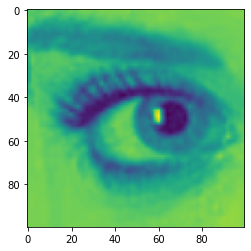

In [4]:
n=35
plt.imshow(X[n].reshape(100,100))
print(Y[n])

In [ ]:
# train_data

In [7]:
labels = pd.read_csv("content/eye_gender_data/Testing_set.csv")
file_paths = [[fname, 'content/eye_gender_data/test/' + fname] for fname in labels['filename']]
data = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])

image_size = 80      # image size taken is 100 here. one can take other size too
test_X = np.array([cv2.resize(cv2.imread(data['filepaths'][i], cv2.IMREAD_GRAYSCALE),(image_size,image_size)).reshape(image_size,image_size,1) for i in range(len(data))])

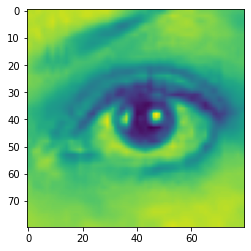

In [8]:
n=35
plt.imshow(test_X[n].reshape(80,80))

In [ ]:
# test_data

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [14]:
# with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
data_augmentation = tf.keras.Sequential([
layers.experimental.preprocessing.RandomFlip("horizontal"),
layers.experimental.preprocessing.RandomRotation(0.1),
layers.experimental.preprocessing.RandomContrast(0.7),
layers.experimental.preprocessing.RandomZoom(0.5),
layers.experimental.preprocessing.RandomCrop(80,80)

])
# data_augmentation.build(input_shape=(1,100,100,1))


In [ ]:
# for i in range(16):
#   augmented_image = data_augmentation(X[0].reshape(1,100,100,1))
#   ax = plt.subplot(4, 4, i + 1)
#   plt.imshow(np.array(augmented_image[0]).reshape(80,80))
#   plt.axis("off")


In [19]:
@njit(Parallel=True)
def call(i):
  global X_aug
  global Y_aug
  augmented_image = data_augmentation(image.reshape(1,100,100,1))
  X_aug.append(np.array(augmented_image).reshape(80,80,1))
  Y_aug.append(label)

In [20]:
  X_aug=[]
  Y_aug=[]
  c=0
  for (image,label) in zip(X,Y):
    print(c)
    c=c+1
    for i in range(32):
      augmented_image = data_augmentation(image.reshape(1,100,100,1))
      X_aug.append(np.array(augmented_image).reshape(80,80,1))
      Y_aug.append(label)
  X_aug=np.array(X_aug)
  Y_aug=np.array(Y_aug)
  np.save('X',X_aug)
  np.save('Y',Y_aug)  

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
X_aug=np.load('X.npy')
Y_aug=np.load('Y.npy')

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_aug,Y_aug,test_size=0.1,random_state=42)

In [ ]:
len(y_train),len(y_test)

In [ ]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    # bn =relu
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_model():
    
    inputs = Input(shape=(80, 80, 1))
    num_filters = 64
    
    # t = BatchNormalization()(inputs)
    t= inputs
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    num_blocks_list = [2, 5, 5, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
            t = Dropout(0.3)(t)
        num_filters *= 2
    
    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(64, activation='relu')(t)
    outputs = Dense(1, activation='sigmoid')(outputs)

    model = Model(inputs, outputs)

    # model.compile(
    #     optimizer='adam',
    #     loss='binary_crossentropy',
    #     metrics=['accuracy']
    # )
    model.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
               metrics=['accuracy'])    

    return model

In [ ]:
# # from tensorflow.contrib.tpu.python.tpu import keras_support

# def create_model():
#   model = tf.keras.Sequential()

#   # #add layers to the model 
#   # model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
#   # model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
#   # model.add(tf.keras.layers.Dropout(0.3))

#   # model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
#   # model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
#   # model.add(tf.keras.layers.Dropout(0.3))

#   # model.add(tf.keras.layers.Flatten())
#   # model.add(tf.keras.layers.Dense(256, activation='relu'))
#   # model.add(tf.keras.layers.Dropout(0.5))
#   # model.add(tf.keras.layers.Dense(10, activation='softmax'))

#   model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
#   model.add(layers.MaxPooling2D((2, 2)))
#   model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
#   model.add(layers.MaxPooling2D((2, 2)))
#   model.add(layers.Conv2D(64, (3, 3), activation='relu',padding ='same', kernel_initializer='he_uniform'))
#   model.add(tf.keras.layers.Dropout(0.3))  
#   model.add(layers.Conv2D(64, (3, 3), activation='relu',padding ='same', kernel_initializer='he_uniform'))
#   model.add(tf.keras.layers.Dropout(0.3))  
#   model.add(layers.Conv2D(64, (3, 3), activation='relu',padding ='same', kernel_initializer='he_uniform'))
#   model.add(tf.keras.layers.Dropout(0.3))      
#   model.add(layers.Conv2D(64, (3, 3), activation='relu',padding ='same', kernel_initializer='he_uniform'))
#   model.add(tf.keras.layers.Dropout(0.3)) 
#   model.add(layers.Conv2D(64, (3, 3), activation='relu',padding ='same', kernel_initializer='he_uniform'))
#   model.add(tf.keras.layers.Dropout(0.3)) 
#   model.add(layers.Conv2D(64, (3, 3), activation='relu',padding ='same', kernel_initializer='he_uniform'))
#   model.add(tf.keras.layers.Dropout(0.3)) 
#   model.add(layers.Conv2D(64, (3, 3), activation='relu',padding ='same', kernel_initializer='he_uniform'))
#   model.add(tf.keras.layers.Dropout(0.3))         
#   # model.add(layers.Conv2D(64, (3, 3), activation='relu',padding ='same'))
#   model.add(layers.Conv2D(64, (3, 3), activation='relu',padding ='same', kernel_initializer='he_uniform'))
#   model.add(layers.MaxPooling2D((2, 2)))
#   model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#   model.add(layers.MaxPooling2D((2, 2)))
#   # model.add(tf.keras.layers.Dropout(0.3))
#   model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#   # model.add(layers.MaxPooling2D((2, 2)))

#   # # model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#   # # model.add(layers.MaxPooling2D((2, 2)))
#   # # model.add(layers.Conv2D(64, (3, 3), activation='relu'))

#   model.add(layers.Flatten())
#   model.add(layers.Dense(256, activation='relu'))
#   model.add(layers.Dense(256, activation='relu'))
#   model.add(layers.Dense(64, activation='relu'))    
#   model.add(layers.Dense(1,activation='sigmoid'))

#   #compile the model 
#   model.compile(loss='binary_crossentropy',
#                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
#                metrics=['accuracy'])

#   # #flag to run on tpu 
#   # if tpu:
#   #   tpu_grpc_url = "grpc://"+os.environ["COLAB_TPU_ADDR"]
    
#   #   #connect the TPU cluster using the address 
#   #   tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu_grpc_url)
    
#   #   #run the model on different clusters 
#   #   strategy = keras_support.TPUDistributionStrategy(tpu_cluster_resolver)
    
#   #   #convert the model to run on tpu 
#   #   model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=strategy)
#   return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model = create_model()
# model.summary()

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=128,
                    validation_data=(X_test, y_test))
# history = model.fit_generator(it, steps_per_epoch=30, 
#                     validation_data=(X_test, y_test))

In [ ]:
preds = model.predict(X_test)
# preds = ['male' if preds[i] <=0.5 else 'female' for i in range(len(preds))]
preds = [0.0 if preds[i] <=0.5 else 1.0 for i in range(len(preds))]

In [ ]:
n=4
print(preds[n])
plt.imshow(X_test[n].reshape(80,80))

In [ ]:
print("Accuracy="+str(accuracy_score(y_test,preds)))

In [ ]:
y_test[:10]

In [ ]:
preds[:10]

In [ ]:
print('label')
final_preds=model.predict(test_X)
for i in range(len(final_preds)):
  ans= 'male' if final_preds[i] <=0.5 else 'female'
  print(ans)